# Create 100 foot buffer around buildings

To make sure buffer areas are accurate, transform data to an equal area projection. We will use California Teale-Albers (EPSG: 3310). 

In [45]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from geopandas import GeoDataFrame

sys.path.append("../utils")

import config

# pd.set_option("display.max_colwidth", None)

In [46]:
# Import SB buildings dataset
sb_buildings_path = os.path.join(
    config.data_dir, "microsoft_buildings", "sb_buildings.geojson"
)

sb_buildings = gpd.read_file(sb_buildings_path)
sb_buildings = sb_buildings.to_crs("EPSG:3310")
sb_buildings = sb_buildings.drop(columns=["index_right"])

# How many buildings are there in Santa Barbara?
print(f" There are {len(sb_buildings)} buildings in Santa Barbara.")

 There are 130464 buildings in Santa Barbara.


In [47]:
# Import joined parcel data
joined_2022_path = os.path.join(
    config.data_dir, "joined_inspections_parcels", "joined_2022.geojson"
)
joined_2022 = gpd.read_file(joined_2022_path)
joined_2022 = joined_2022.to_crs("EPSG:3310")
joined_2022 = joined_2022.drop(columns=["index_right"])

# How many inspected parcels are there in Santa Barbara?
print(f"In 2022, {len(joined_2022)} parcels were inspected.")

In 2022, 13809 parcels were inspected.


### Subset buildings to those that fall within inspected parcels

In [48]:
# Spatial join to find buildings within joined_2022 geometries
result = gpd.sjoin(sb_buildings, joined_2022, how="inner", predicate="within")

# How many buildings are on inspected parcels?
print(f"Inspected buildings: {len(result)}")

Inspected buildings: 29305


**Note that `result['geometry_right']` is the geometry of the joined_2022 parcels and `result['geometry']` is the geometry of the buildings.*

There are more buildings than parcels. There could be multiple buildings on each parcel (multi-family units, auxiliary structures) and the Microsoft Buildings dataset detects these as buildings. 

For the purposes of our current analysis, we will make the assumption that the largest building on each parcel is the structure being inspected for defensible space compliance. 

#### Check to make sure that the buildings were subsetted properly

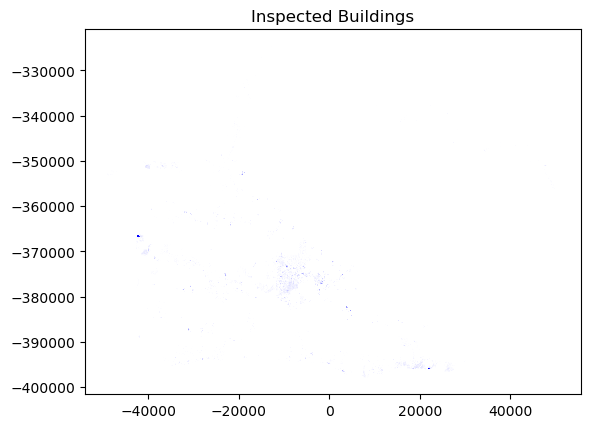

In [49]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the buildings
result.plot(ax=ax, color="blue", label="Buildings")

# Add labels and legend
plt.title("Inspected Buildings")
plt.show()

### Buffer buildings polygons

Create a 100 foot buffer around all of the building polygons. 100 feet = ~30.48 meters.

In [50]:
# Create a buffer for the building polygons
sb_buildings_buffered = result.copy()
sb_buildings_buffered["geometry"] = result.geometry.buffer(
    30.48, resolution=50, cap_style=3, join_style=2
).envelope

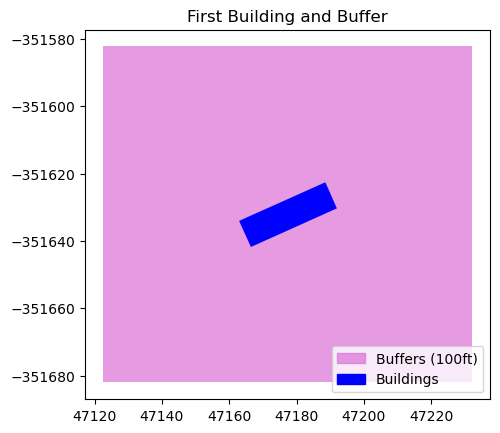

In [51]:
# Create a figure and axis
fig, ax = plt.subplots()

# Create patches for the legend
buffer_patch = plt.Rectangle((0, 0), 1, 1, color="orchid", alpha=0.7)
building_patch = plt.Rectangle((0, 0), 1, 1, color="blue")

# Plot the buffered buildings
sb_buildings_buffered.geometry.head(1).plot(
    ax=ax, color="orchid", alpha=0.7, label="Buffers (100ft)"
)

# Plot the buildings
result.head(1).plot(ax=ax, color="blue", label="Buildings")

# Add labels and legend
plt.title("First Building and Buffer")
ax.legend(
    [buffer_patch, building_patch], ["Buffers (100ft)", "Buildings"], loc="lower right"
)
plt.show()

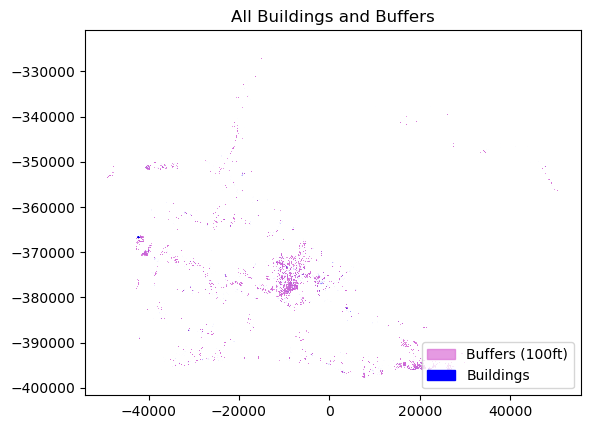

In [52]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the buffers
sb_buildings_buffered.plot(ax=ax, alpha=0.7, color="orchid")

# Plot the buildings
result.plot(ax=ax, color="blue", label="Buildings")

# Add labels and legend
plt.title("All Buildings and Buffers")
ax.legend(
    [buffer_patch, building_patch], ["Buffers (100ft)", "Buildings"], loc="lower right"
)
plt.show()

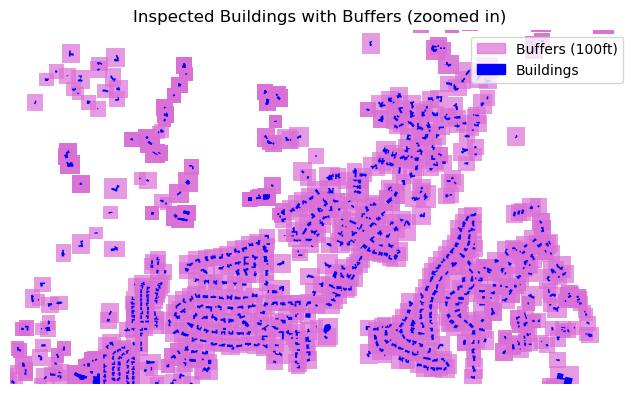

In [53]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the buffers
sb_buildings_buffered.plot(ax=ax, alpha=0.7, color="orchid")

# Plot the buildings
result.plot(ax=ax, color="blue")

# Set axis limits to zoom in
ax.set_xlim(18000, 21500)
ax.set_ylim(-396000, -394000)

# Add labels and legend
plt.title("Inspected Buildings with Buffers (zoomed in)")
ax.legend(
    [buffer_patch, building_patch], ["Buffers (100ft)", "Buildings"], loc="upper right"
)
ax.axis("off")
plt.show()

### Clip building buffers to parcels

The 100 foot buffers for buildings tend to overlap, meaning we need to clip to each parcel since compliance status is determined based on property ownership. 

In [54]:
# Join buffers to parcel data
clipped_buildings = gpd.overlay(sb_buildings_buffered, joined_2022, how='intersection')

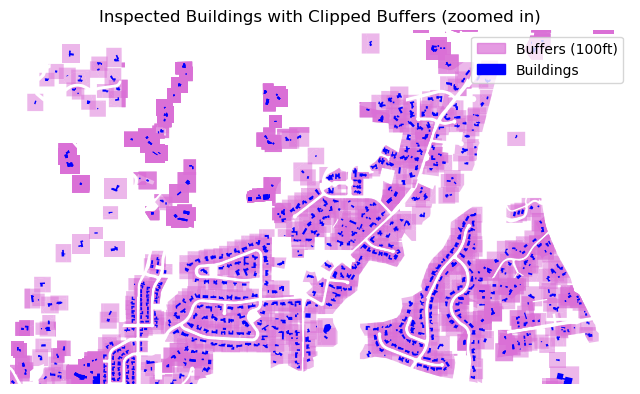

In [55]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the buffers
clipped_buildings.plot(ax=ax, alpha=0.5, color="orchid")

# Plot the buildings
result.plot(ax=ax, color="blue")

# Set axis limits to zoom in
ax.set_xlim(18000, 21500)
ax.set_ylim(-396000, -394000)

# Add labels and legend
plt.title("Inspected Buildings with Clipped Buffers (zoomed in)")
ax.legend(
    [buffer_patch, building_patch], ["Buffers (100ft)", "Buildings"], loc="upper right"
)
ax.axis("off")
plt.show()

### Remove smaller buildings on parcels

In [56]:
# Calculate the area of each clipped building
clipped_buildings["area"] = clipped_buildings.geometry.area

# Get the largest building per parcel
largest_buildings = clipped_buildings.sort_values(
    "area", ascending=False
).drop_duplicates(subset="apn_left_2")

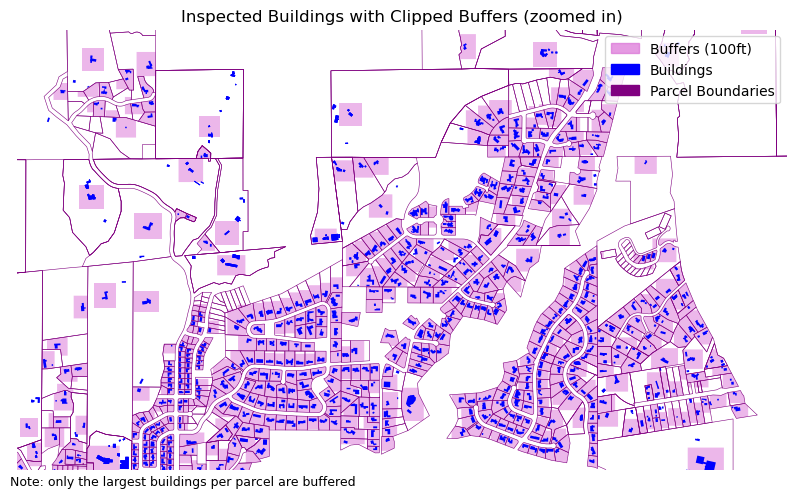

In [57]:
# Plot to confirm the largest building per parcel was kept
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the buffers
largest_buildings.plot(ax=ax, alpha=0.5, color="orchid")

# Plot the buildings
result.plot(ax=ax, color="blue")

# Plot the parcel boundaries
joined_2022.boundary.plot(ax=ax, color="purple", linewidth=0.4)

# Set axis limits to zoom in
ax.set_xlim(18000, 21500)
ax.set_ylim(-396000, -394000)

# Add labels and legend
parcels_patch = plt.Rectangle((0, 0), 1, 1, color="purple")

plt.title("Inspected Buildings with Clipped Buffers (zoomed in)")
plt.figtext(
    0.01,
    0.10,
    "Note: only the largest buildings per parcel are buffered",
    fontsize=9,
)
ax.legend(
    [buffer_patch, building_patch, parcels_patch],
    ["Buffers (100ft)", "Buildings", "Parcel Boundaries"],
    loc="upper right",
)
ax.axis("off")
plt.tight_layout()
plt.subplots_adjust(bottom=0.01)
plt.show()